In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_curve
from tqdm import tqdm
import imblearn
import random
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
data = pd.read_pickle("./data.pkl")
## Remove columns of languages
# data = data.iloc[:,0:12]

In [3]:

categorical_columns = [data.columns.get_loc(c) for c in data.select_dtypes(exclude=["number"]).columns if c in data]

# split data into X and y
X = data.loc[:, data.columns != 'bot']
Y = data.loc[:, data.columns == 'bot'].to_numpy()

# split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [4]:
# Oversampling of training set

X_train_majority = X_train[y_train < 1] # human (non-bots) => label 0 : are majority
X_train_minority = X_train[y_train > 0]


In [5]:
N = np.shape(y_train)[0]

pi_mi = y_train.sum()/np.shape(y_train)[0]
pi_mi

0.2706835443037975

In [6]:
X_train_majority = X_train_majority.to_numpy()
X_train_minority = X_train_minority.to_numpy()

y_test = np.where(y_test < 0.5, -1, 1)

y_train = y_train.flatten()
y_test = y_test.flatten()

In [7]:
#betas = [i for i in list(np.linspace(0.1,0.9,11))]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99999]
# betas = [0.9]
f1scores_under = []
accuracy_under = []

for Beta in tqdm(betas):

    # Update x2D_ma
    X_train_majority_undersampled = X_train_majority[random.sample(range(1, int((1-pi_mi)*N)),int(Beta*(1-pi_mi)*N)), :]
    X_train = np.r_[X_train_majority_undersampled,X_train_minority]
    y_train = np.r_[[-1]*len(X_train_majority_undersampled), [1]*len(X_train_minority)]

    number_iterations = 100

    number_samples = np.shape(X_train)[0]
    
    print("Number of samples: "+str(number_samples))

    weights = np.ones(number_samples)/number_samples

    # There will be as many weak learners as iterations
    weak_learners = np.zeros(shape=number_iterations, dtype=object)

    significance_vec = np.zeros(shape=number_iterations)

    error_vec = []
    accuracy_vec = []

    for iterations in range(number_iterations):

        current_weights = weights

        weak_learner = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        weak_learner_model = weak_learner.fit(X_train, y_train, sample_weight=current_weights)


        # The new weak learner model is saved
        weak_learners[iterations] = weak_learner_model

        weak_learner_pred = weak_learner_model.predict(X_train)

        error = 0
        incorrect_pred = 0
        correct_pred = 0

        for item_index in range(number_samples):

            if weak_learner_pred[item_index] != y_train[item_index]:
                incorrect_pred = incorrect_pred + 1
                error = error + current_weights[item_index]
            else: 
                correct_pred = correct_pred + 1 

        # Save error for plotting    
        error_vec.append(error)

        # Significance of the weak learner model is calculated and saved

        significance = 0.5*np.log((1-error)/error) 

        significance_vec[iterations] = significance

        #########################

        # Update weights for each sample

        for item_index in range(number_samples):
            if weak_learner_pred[item_index] != y_train[item_index]:

                weights[item_index] = np.multiply(current_weights[item_index],np.exp(significance))

            else:
                weights[item_index] = current_weights[item_index]*np.exp(-significance)

        # Alternative
        # weights = current_weights * np.exp(-significance*  y_train * weak_learner_pred)


        #########################

        # Normalize weights

        weights /= weights.sum()
        
        
    # Get prediction of each weak learner 
    model_preds = np.array([model.predict(X_test) for model in weak_learners])
    y_test_pred = np.sign(np.dot(significance_vec, model_preds))

    # Calculate accuracy 
    
    correct_pred = 0

    for item_index in range(np.shape(y_test_pred)[0]):

            if y_test_pred[item_index] == y_test[item_index]:

                correct_pred = correct_pred + 1 
                
    accuracy = correct_pred/np.shape(y_test_pred)[0]

    print("Accuracy = " + str(accuracy))
    
#     # F1 Score
#     f1_score = f1_score(y_test, y_test_pred, average='weighted')
#     print("F1 Score Adaboost: " + str(f1_score))
    
    # Record results
#     f1scores_under.append(f1_score)
    accuracy_under.append(accuracy)

    

  0%|          | 0/10 [00:00<?, ?it/s]

Number of samples: 6786


 10%|█         | 1/10 [00:10<01:31, 10.12s/it]

Accuracy = 0.6384006578271149
Number of samples: 8226


 20%|██        | 2/10 [00:21<01:23, 10.42s/it]

Accuracy = 0.741083359029705
Number of samples: 9667


 30%|███       | 3/10 [00:33<01:16, 10.87s/it]

Accuracy = 0.7915510329941412
Number of samples: 11107


 40%|████      | 4/10 [00:46<01:09, 11.65s/it]

Accuracy = 0.8064549285640867
Number of samples: 12548


 50%|█████     | 5/10 [01:03<01:06, 13.34s/it]

Accuracy = 0.8246479597080892
Number of samples: 13988


 60%|██████    | 6/10 [01:27<01:06, 16.56s/it]

Accuracy = 0.8324596566964745
Number of samples: 15428


 70%|███████   | 7/10 [01:56<01:00, 20.12s/it]

Accuracy = 0.8343097954568814
Number of samples: 16869


 80%|████████  | 8/10 [02:13<00:38, 19.33s/it]

Accuracy = 0.8366738616507349
Number of samples: 18309


 90%|█████████ | 9/10 [02:37<00:20, 20.66s/it]

Accuracy = 0.8495220474868949
Number of samples: 19749


100%|██████████| 10/10 [03:09<00:00, 23.92s/it]

Accuracy = 0.8451022715592559


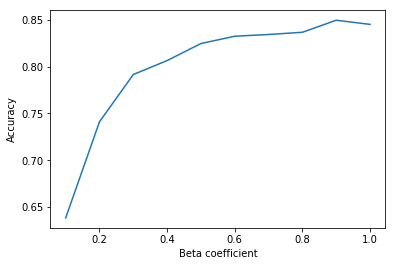

In [8]:
plt.plot(betas,accuracy_under)
plt.xlabel("Beta coefficient")
plt.ylabel("Accuracy")
plt.show()

In [9]:
# Maximum seems to occur in beta = 0.9

from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

          -1       0.87      0.92      0.90      7144
           1       0.75      0.63      0.68      2585

    accuracy                           0.85      9729
   macro avg       0.81      0.78      0.79      9729
weighted avg       0.84      0.85      0.84      9729

